# Imports

In [1]:
import os
import datetime
import glob
import requests
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

%matplotlib inline

# Download and extract data

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip'
file_name = url.split('/')[-1]

if not os.path.exists(file_name):
    with requests.get(url, stream=True) as response, open(file_name, 'wb') as file:
        print(f'Downloading {file_name}...')
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    with zipfile.ZipFile(file_name) as zip_file:
        print(f'Extracting {file_name}...')
        zip_file.extractall()

# Read data to memory and write to csv

In [3]:
DATA_DIR = 'data'
DATA_PATH = 'data/har.csv'
RAW_DATA_DIR = 'wisdm-dataset/raw/watch'

ACTIVITY_MAP = {
    'A' : 'walking',
    'B' : 'jogging', 
    'C' : 'stairs', 
    'D' : 'sitting', 
    'E' : 'standing'
} 

def read_watch_data():
    if os.path.exists(DATA_PATH):
        return pd.read_csv(DATA_PATH)
    sensor_dfs = []
    columns = ['subject', 'activity', 'timestamp']
    for sensor in ['accel', 'gyro']:
        files = sorted(glob.glob(os.path.join(os.path.join(RAW_DATA_DIR, sensor), '*.txt')))
        df = pd.concat([pd.read_csv(file, header=None) for file in files], axis=0, ignore_index=True)
        df.columns = columns + [sensor + '_' + axis for axis in 'xyz']
        df[sensor + '_z'] = df[sensor + '_z'].str.replace(';', '', regex=False).astype(float)
        df = df.loc[df['activity'].isin(ACTIVITY_MAP.keys())]
        df['activity'] = df['activity'].map(ACTIVITY_MAP)
        sensor_dfs.append(df)
    har_df = pd.merge(sensor_dfs[0], sensor_dfs[1], on=columns)
    har_df = har_df.dropna()
    har_df = har_df.drop_duplicates()
    os.makedirs(DATA_DIR, exist_ok=True)
    har_df.to_csv(DATA_PATH, index=False)
    return har_df

In [4]:
har_df = read_watch_data()
display(har_df.head())
display(har_df.shape)

,subject,activity,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,1600,walking,90426757696641,4.972757,-0.158317,6.696732,0.314944,-1.022277,-0.309962
1,1600,walking,90426807196641,3.253720,-0.191835,6.107758,0.387382,-0.618541,-0.048972
2,1600,walking,90426856696641,2.801216,-0.155922,5.997625,0.070999,-0.209480,-0.195978
3,1600,walking,90426906196641,3.770868,-1.051354,7.731027,0.037975,0.254976,-0.156563
4,1600,walking,90426955696641,4.661511,0.169689,9.684695,0.073129,0.719431,-0.001035


(884901, 9)

In [5]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884901 entries, 0 to 884900
Data columns (total 9 columns):
subject      884901 non-null int64
activity     884901 non-null object
timestamp    884901 non-null int64
accel_x      884901 non-null float64
accel_y      884901 non-null float64
accel_z      884901 non-null float64
gyro_x       884901 non-null float64
gyro_y       884901 non-null float64
gyro_z       884901 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 60.8+ MB


In [6]:
FEATURES = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

stats_df = har_df[FEATURES].describe().loc[['count','mean','std','min','max']].round(3)
stats_df.style.applymap(color_negative_red)

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
count,884901,884901,884901,884901,884901,884901
mean,4.063,-3.527,1.454,-0.057,-0.007,0.002
std,7.435,5.785,4.934,1.653,1.386,1.724
min,-57.397,-61.974,-48.981,-34.859,-18.897,-20.407
max,35.765,23.035,42.519,34.905,19.104,15.349


### Clip values to -30 and 30

In [7]:
har_df[FEATURES] = har_df[FEATURES].clip(-30, 30)

In [8]:
har_df[FEATURES].describe().loc[['count','mean','std','min','max']].round(3)

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
count,884901.000,884901.000,884901.000,884901.000,884901.000,884901.000
mean,4.064,-3.524,1.454,-0.057,-0.007,0.002
std,7.431,5.769,4.933,1.652,1.386,1.724
min,-30.000,-30.000,-30.000,-30.000,-18.897,-20.407
max,30.000,23.035,30.000,30.000,19.104,15.349


# Exploratory Data Analysis

In [9]:
with pd.option_context('display.max_rows', None):
    display(pd.pivot_table(har_df, index=har_df.columns[:2].tolist(), aggfunc='count'))

accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z  timestamp
subject activity                                                              
1600    jogging      3604     3604     3604    3604    3604    3604       3604
        sitting      3604     3604     3604    3604    3604    3604       3604
        stairs       3604     3604     3604    3604    3604    3604       3604
        standing     3604     3604     3604    3604    3604    3604       3604
        walking      3603     3603     3603    3603    3603    3603       3603
1601    jogging      3602     3602     3602    3602    3602    3602       3602
        sitting      3601     3601     3601    3601    3601    3601       3601
        stairs       3601     3601     3601    3601    3601    3601       3601
        standing     3602     3602     3602    3602    3602    3602       3602
        walking      3601     3601     3601    3601    3601    3601       3601
1602    jogging      3603     3603     3603    3603    3603    3603       3603
        sitting      3603     3603     3603    3603    3603    3603       3603
        stairs       3603     3603     3603    3603    3603    3603       3603
        standing     3699     3699     3699    3699    3699    3699       3699
        walking      3603     3603     3603    3603    3603    3603       3603
1603    jogging      3602     3602     3602    3602    3602    3602       3602
        sitting      3603     3603     3603    3603    3603    3603       3603
        stairs       3602     3602     3602    3602    3602    3602       3602
        standing     3601     3601     3601    3601    3601    3601       3601
        walking      3603     3603     3603    3603    3603    3603       3603
1604    jogging      3603     3603     3603    3603    3603    3603       3603
        sitting      3603     3603     3603    3603    3603    3603       3603
        stairs       3604     3604     3604    3604    3604    3604       3604
        standing     3603     3603     3603    3603    3603    3603       3603
        walking      3603     3603     3603    3603    3603    3603       3603
1605    jogging      3603     3603     3603    3603    3603    3603       3603
        sitting      3602     3602     3602    3602    3602    3602       3602
        stairs       3602     3602     3602    3602    3602    3602       3602
        standing     3602     3602     3602    3602    3602    3602       3602
        walking      3603     3603     3603    3603    3603    3603       3603
1606    jogging      3603     3603     3603    3603    3603    3603       3603
        sitting      3603     3603     3603    3603    3603    3603       3603
        stairs       3603     3603     3603    3603    3603    3603       3603
        standing     3603     3603     3603    3603    3603    3603       3603
        walking      3603     3603     3603    3603    3603    3603       3603
1607    jogging      3602     3602     3602    3602    3602    3602       3602
        sitting      3601     3601     3601    3601    3601    3601       3601
        stairs       3602     3602     3602    3602    3602    3602       3602
        standing     3602     3602     3602    3602    3602    3602       3602
        walking      3603     3603     3603    3603    3603    3603       3603
1608    jogging      3603     3603     3603    3603    3603    3603       3603
        sitting      3603     3603     3603    3603    3603    3603       3603
        stairs       3603     3603     3603    3603    3603    3603       3603
        standing     3603     3603     3603    3603    3603    3603       3603
        walking      3603     3603     3603    3603    3603    3603       3603
1609    jogging      3603     3603     3603    3603    3603    3603       3603
        sitting      3603     3603     3603    3603    3603    3603       3603
        stairs       3603     3603     3603    3603    3603    3603       3603
        standing     3603     3603     3603    3603    3603    3603 

### Readings for subjects 1637, 1638, 1639, and 1640 look out of 'shape'. Numerous data points most likely got dropped because of varying timestamps while merging rendering them unreliable. Let's plot to confirm.

In [10]:
def plot_sensor_readings(sensor, subject, start=0, end=1024):
    for activity in ACTIVITY_MAP.values():
        data = har_df.query(f'subject == {subject} and activity == "{activity}"')[start:end]
        if len(data) == 0:
            continue
        fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20, 10), sharex=True)
        plot_axis(ax0, data['timestamp'], data[sensor + '_x'], 'X-Axis')
        plot_axis(ax1, data['timestamp'], data[sensor + '_y'], 'Y-Axis')
        plot_axis(ax2, data['timestamp'], data[sensor + '_z'], 'Z-Axis')
        plt.subplots_adjust(hspace=0.2)
        fig.suptitle(sensor.upper() + ' :: ' + activity.upper())
        plt.subplots_adjust(top=0.90)
        plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

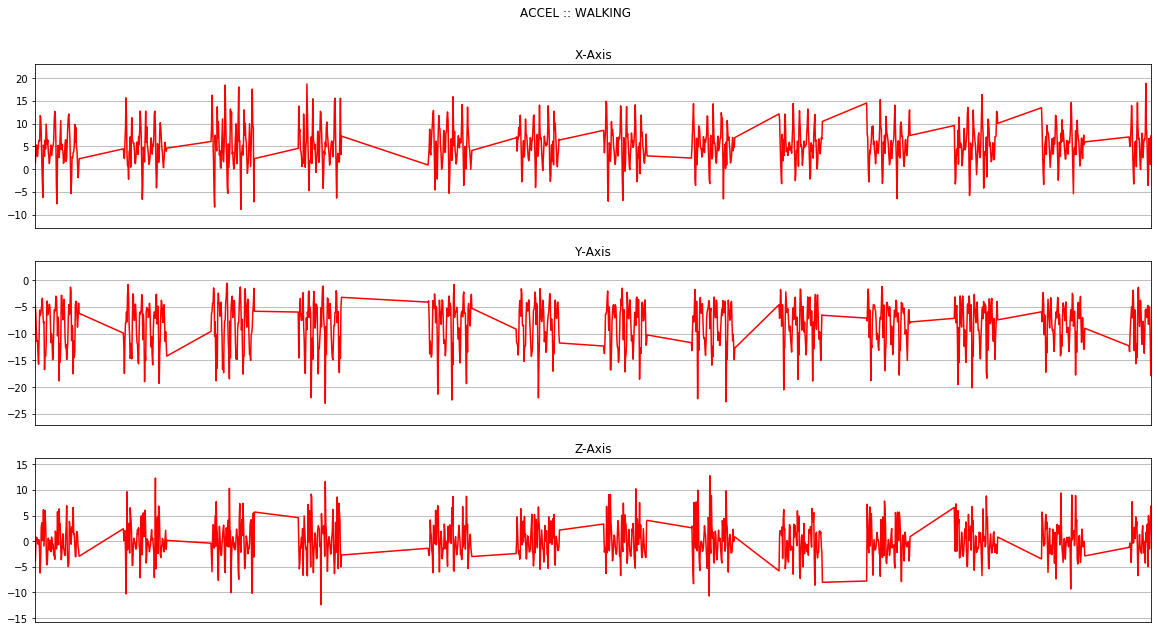

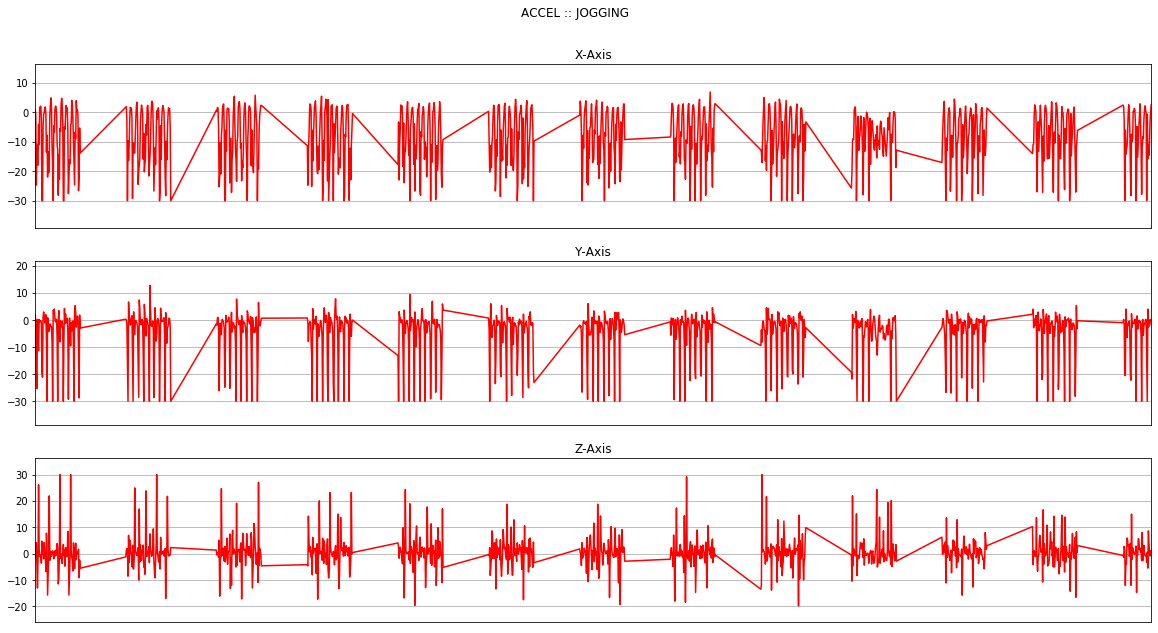

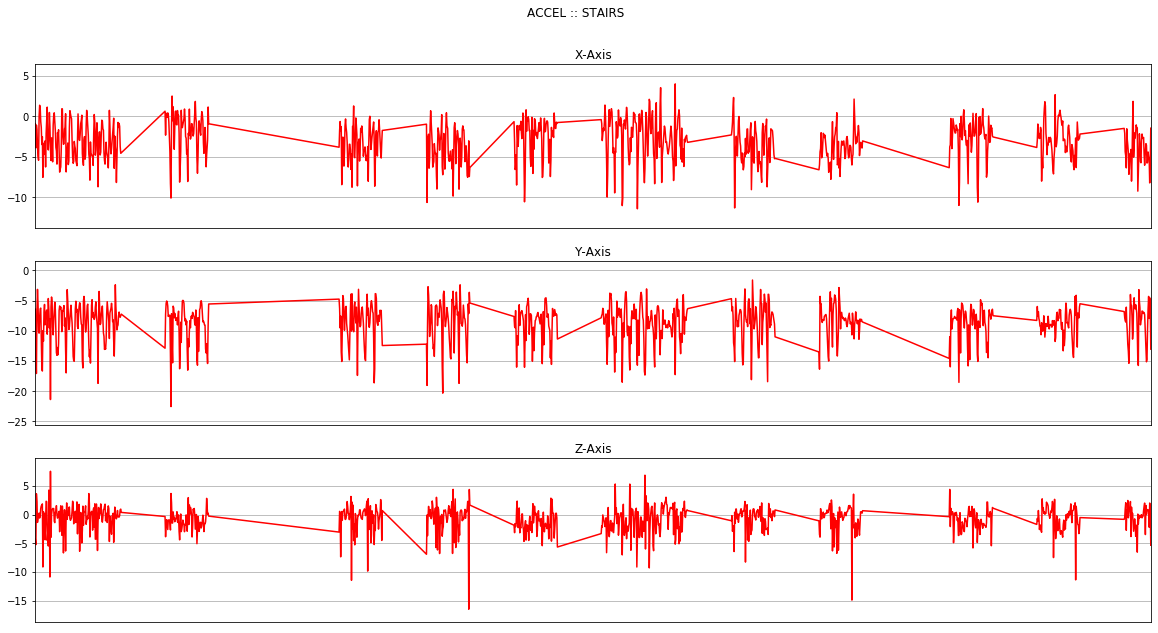

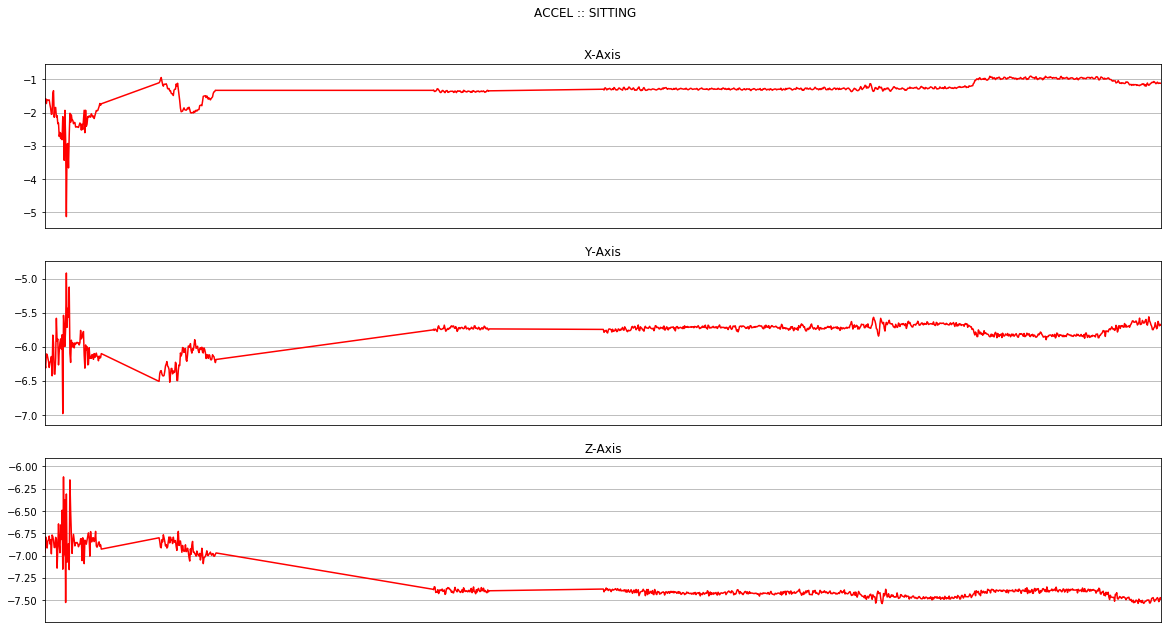

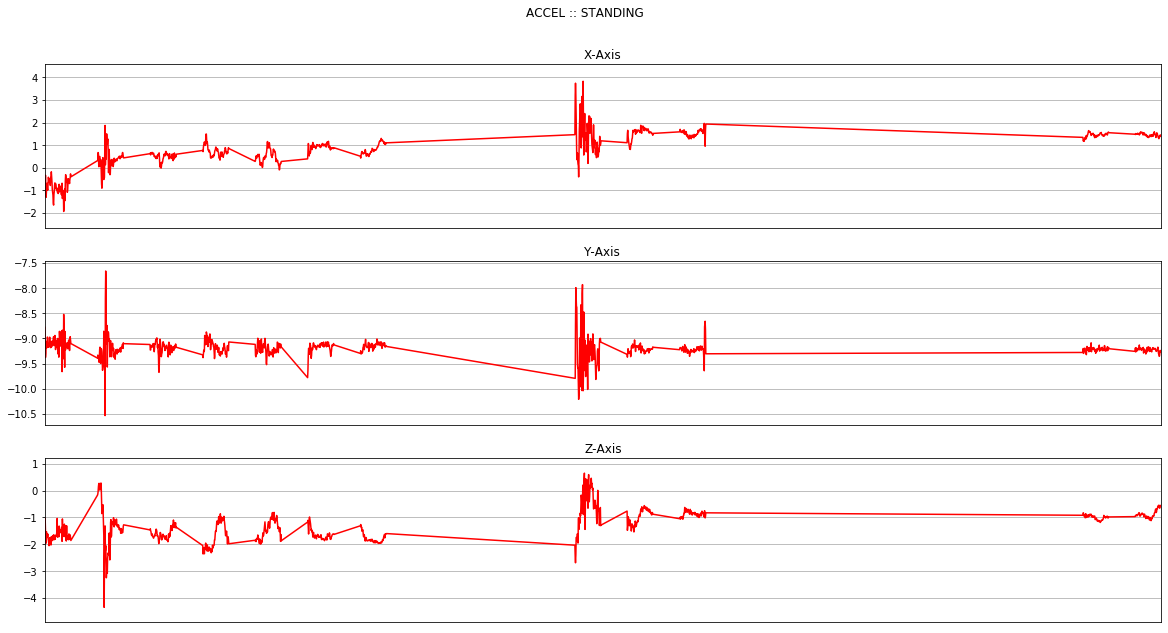

In [11]:
plot_sensor_readings('accel', 1638)

### Drop data for subjects 1637 to 1640 inclusive.

In [12]:
har_df = har_df.loc[~har_df['subject'].isin([1637, 1638, 1639, 1640])].reset_index()

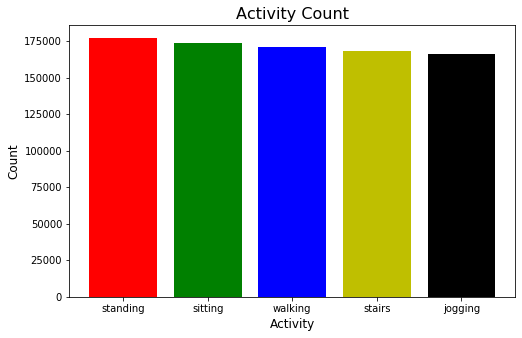

In [13]:
activity_count = har_df.activity.value_counts()

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(activity_count.index, activity_count.values, color=['r', 'g', 'b', 'y', 'k'])
ax.set_title('Activity Count', {'fontsize': 16})
ax.set_xlabel('Activity', {'fontsize': 12})
ax.set_ylabel('Count', {'fontsize': 12})
ax.figure.savefig('activity_count.png')

# Train and evaluate

In [14]:
SEQ_LEN = 60 # corresponding to 3 secs (20 * 3). Data was sampled at 20 Hz.
COLUMNS = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
DIMS = len(COLUMNS)

In [15]:
scaler = MinMaxScaler()
har_df[COLUMNS] = scaler.fit_transform(har_df[COLUMNS])

encoder = LabelEncoder()
har_df['activity'] = encoder.fit_transform(har_df['activity'])

In [16]:
X = []
y = []    

for index, data in har_df.groupby(['subject', 'activity'], sort=False):
    data = data[COLUMNS].values
    label = index[1]
    for i in range(0, len(data) - SEQ_LEN, SEQ_LEN):
        X.append(np.expand_dims(data[i:i+SEQ_LEN], axis=0))
        y.append(label)

X = np.concatenate(X)
y = np.asarray(y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=43)

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, input_shape=(SEQ_LEN, DIMS)),
    tf.keras.layers.LSTM(units=32),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 58, 32)            608       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 11,365
Trainable params: 11,365
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train, 
                    batch_size=32,
                    epochs=100, 
                    validation_split=0.2,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), 
                        tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 if epoch < 10 else 0.001 * tf.math.exp(0.1 * (10 - epoch))),
                        tf.keras.callbacks.TensorBoard()
                    ])

Train on 9093 samples, validate on 2274 samples
Epoch 1/100
9093/9093 [==============================] - 6s 690us/sample - loss: 1.3220 - accuracy: 0.4194 - val_loss: 1.1771 - val_accuracy: 0.4675
Epoch 2/100
9093/9093 [==============================] - 5s 513us/sample - loss: 1.0917 - accuracy: 0.5285 - val_loss: 1.0664 - val_accuracy: 0.5150
Epoch 3/100
9093/9093 [==============================] - 5s 499us/sample - loss: 1.0204 - accuracy: 0.5550 - val_loss: 0.9605 - val_accuracy: 0.6003
Epoch 4/100
9093/9093 [==============================] - 4s 470us/sample - loss: 0.9475 - accuracy: 0.5911 - val_loss: 0.8544 - val_accuracy: 0.6658
Epoch 5/100
9093/9093 [==============================] - 4s 483us/sample - loss: 0.8142 - accuracy: 0.6487 - val_loss: 0.8186 - val_accuracy: 0.6451
Epoch 6/100
9093/9093 [==============================] - 4s 473us/sample - loss: 0.7068 - accuracy: 0.7163 - val_loss: 0.8207 - val_accuracy: 0.6570
Epoch 7/100
9093/9093 [==============================] - 4

In [24]:
model.evaluate(X_test, y_test)

2842/2842 [==============================] - 0s 125us/sample - loss: 0.3135 - accuracy: 0.8874


[0.3134698466378815, 0.88740325]